In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, os
import tensorflow as tf
from tensorflow.image import grayscale_to_rgb
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten

In [2]:
data = np.load('/content/drive/MyDrive/Datasets/Sign-language-digits-dataset/X.npy')
label = np.load('/content/drive/MyDrive/Datasets/Sign-language-digits-dataset/Y.npy')

In [3]:
data.shape, label.shape

((2062, 64, 64), (2062, 10))

In [4]:
data = np.concatenate((data[204:409,:],
                  data[822:1028,:],
                  data[1649:1855,:],
                  data[1443:1649,:],
                  data[1236:1443,:],
                  data[1855:2062,:],
                  data[615:822,:],
                  data[409:615,:],
                  data[1028:1236,:],
                  data[0:204,:]),axis = 0)

Text(0.5, 1.0, '0')

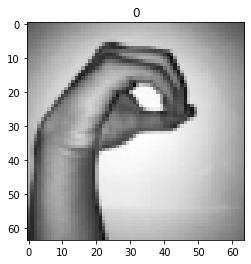

In [5]:
x = random.randint(0,data.shape[0])

plt.imshow(data[x], cmap='gray')
plt.title(np.argmax(label[x]))

In [6]:
X_4d = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
# X = data
# y = np.argmax(label, axis=1).reshape(label.shape[0], 1)
y = label

In [7]:
X_4d.shape, y.shape

((2062, 64, 64, 1), (2062, 10))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_4d,y,random_state=10, 
    test_size=0.2
)

In [9]:
X_train.shape, X_test.shape

((1649, 64, 64, 1), (413, 64, 64, 1))

In [10]:
y_train.shape, y_test.shape

((1649, 10), (413, 10))

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]')

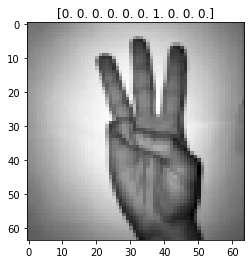

In [11]:
x = random.randint(0,X_train.shape[0])

plt.imshow(X_train[x].reshape(64,64), cmap='gray')
plt.title(y_train[x])

Data Augmentation

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

Model construction

In [36]:
rgb_train = grayscale_to_rgb(tf.constant(X_train)).numpy()
rgb_test = grayscale_to_rgb(tf.constant(X_test)).numpy()

n,w,h,c = rgb_train.shape

resnet = ResNet50(
    input_shape=(w,h,c),
    include_top=False,
    weights='imagenet',
    classes=10
)

# rgb_train.numpy().shape, rgb_test.numpy().shape

(1649, 64, 64, 3) (413, 64, 64, 3) (1649, 10) (413, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


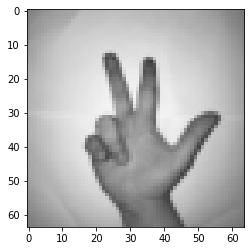

In [37]:
print(rgb_train.shape, rgb_test.shape, y_train.shape, y_test.shape)
print(y_train[0])
plt.imshow(rgb_train[0])

In [38]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [39]:
resnet.trainable = False

In [40]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [41]:
model = Sequential([
                    resnet,
                    Flatten(),
                    Dense(1024, activation=tf.nn.relu),
                    Dense(256, activation=tf.nn.relu),
                    Dense(10, activation=tf.nn.softmax)
], name='Sign_Digits')

In [42]:
model.summary()

Model: "Sign_Digits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 32,242,314
Trainable params: 8,654,602
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [45]:
train_gen = datagen.flow(rgb_train, y_train)
test_gen = datagen.flow(rgb_test, y_test)
initial_epochs = 150

history = model.fit(
    train_gen,
    steps_per_epoch=len(rgb_train)/32,
    epochs=initial_epochs,
    validation_data=test_gen
)

Epoch 1/150
51/51 [==============================] - 6s 71ms/step - loss: 2.4190 - accuracy: 0.1191 - val_loss: 2.2264 - val_accuracy: 0.1525
Epoch 2/150
51/51 [==============================] - 3s 53ms/step - loss: 2.2155 - accuracy: 0.1836 - val_loss: 2.1162 - val_accuracy: 0.2131
Epoch 3/150
51/51 [==============================] - 3s 53ms/step - loss: 2.0989 - accuracy: 0.2258 - val_loss: 2.0963 - val_accuracy: 0.2615
Epoch 4/150
51/51 [==============================] - 3s 52ms/step - loss: 2.1134 - accuracy: 0.2107 - val_loss: 2.1415 - val_accuracy: 0.2252
Epoch 5/150
51/51 [==============================] - 3s 52ms/step - loss: 2.0302 - accuracy: 0.2667 - val_loss: 2.0529 - val_accuracy: 0.2276
Epoch 6/150
51/51 [==============================] - 3s 52ms/step - loss: 1.9498 - accuracy: 0.2998 - val_loss: 1.9853 - val_accuracy: 0.3051
Epoch 7/150
51/51 [==============================] - 3s 52ms/step - loss: 1.9460 - accuracy: 0.3054 - val_loss: 2.0125 - val_accuracy: 0.2930
Epoch 

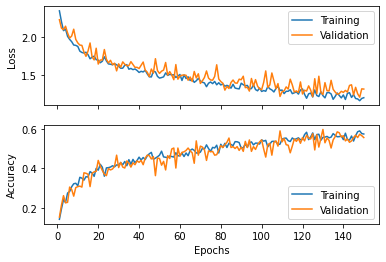

In [46]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1,initial_epochs+1)

fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(epochs, loss, label='Training')
ax[0].plot(epochs, val_loss, label='Validation')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, label='Training')
ax[1].plot(epochs, val_acc, label='Validation')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

In [47]:
model.save('/content/drive/MyDrive/Datasets/Hand-Digits/hand_digits.tf',
           save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Hand-Digits/hand_digits.tf/assets


In [48]:
print(f'Number of layers: {len(resnet.layers)}')
resnet.trainable = True
fine_tune_at = 100

for layer in resnet.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers: 175


In [49]:
# base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/20),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "Sign_Digits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 32,242,314
Trainable params: 28,107,530
Non-trainable params: 4,134,784
_________________________________________________________________


In [51]:
len(model.trainable_variables)

96

In [52]:
fine_tune_epochs = 150
total_epochs = len(history.epoch) + fine_tune_epochs

history_fine = model.fit(train_gen,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_gen)


Epoch 150/300
52/52 [==============================] - 8s 82ms/step - loss: 13.8104 - accuracy: 0.1573 - val_loss: 9.1423 - val_accuracy: 0.1380
Epoch 151/300
52/52 [==============================] - 3s 64ms/step - loss: 3.1866 - accuracy: 0.2180 - val_loss: 12.9450 - val_accuracy: 0.1090
Epoch 152/300
52/52 [==============================] - 3s 62ms/step - loss: 2.1651 - accuracy: 0.2698 - val_loss: 9.9247 - val_accuracy: 0.1186
Epoch 153/300
52/52 [==============================] - 3s 62ms/step - loss: 2.0094 - accuracy: 0.2879 - val_loss: 8.3984 - val_accuracy: 0.1211
Epoch 154/300
52/52 [==============================] - 3s 63ms/step - loss: 1.8562 - accuracy: 0.3693 - val_loss: 3.3440 - val_accuracy: 0.1671
Epoch 155/300
52/52 [==============================] - 3s 63ms/step - loss: 1.7874 - accuracy: 0.3803 - val_loss: 2.3232 - val_accuracy: 0.2228
Epoch 156/300
52/52 [==============================] - 3s 62ms/step - loss: 1.7018 - accuracy: 0.3901 - val_loss: 1.9451 - val_accurac

In [53]:
model.save('/content/drive/MyDrive/Datasets/Hand-Digits/hand_digits.tf', 
           save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Hand-Digits/hand_digits.tf/assets


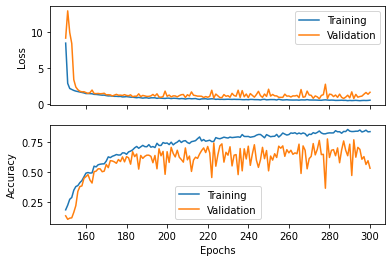

In [57]:
loss = history_fine.history['loss']
acc = history_fine.history['accuracy']
val_loss = history_fine.history['val_loss']
val_acc = history_fine.history['val_accuracy']
epochs = range(fine_tune_epochs,fine_tune_epochs+len(history_fine.epoch))

fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(epochs, loss, label='Training')
ax[0].plot(epochs, val_loss, label='Validation')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, label='Training')
ax[1].plot(epochs, val_acc, label='Validation')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

In [58]:
loaded_model = load_model('/content/drive/MyDrive/Datasets/Hand-Digits/hand_digits.tf')

In [59]:
loaded_model.summary()

Model: "Sign_Digits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 32,242,314
Trainable params: 32,189,194
Non-trainable params: 53,120
_________________________________________________________________


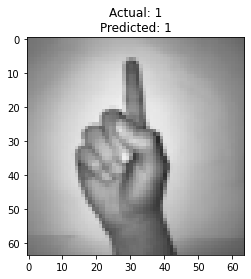

In [68]:
x = random.randint(0,len(rgb_test))

y_pred = model.predict(rgb_test[x].reshape(1,64,64,3))
actual_label = np.argmax(y_test[x])
pred_label = np.argmax(y_pred)
plt.imshow(rgb_test[x])
plt.title(f'Actual: {actual_label}\nPredicted: {pred_label}');